# 마르코프 국면전환 모델을 이용한 코스피 시장 국면 관측

## 본 코드는 다음의 사이트를 참조하여 제작함을 미리 알려드립니다. 모델의 세부내용은 다음의 사이트에서 확인해주시면 감사하겠습니다.

### 출처 : https://sarit-maitra.medium.com/markov-regime-switching-non-linear-model-8ebfdf6eb755

# 1. 필요 라이브러리 설치 및 데이터 전처리(KOSPI)

## 전처리 과정은 시계열데이터를 노이즈를 감소시키게 하기 위해서 이동평균을 해주었습니다.
## 정상성 역시 만족시키기 위해서 차분을 해줍니다. (pct_change 함수)


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import xlrd
# import FinanceDataReader as fdr
# from arch import arch_model

import statsmodels.api as sm
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [73]:
fn= "KOSPI_1995.xlsx"
df_Kospi= pd.read_excel(fn)
df_Kospi= df_Kospi.iloc[:,4:].T

header= df_Kospi.index.tolist()
H= list(map(lambda x: datetime.datetime.strptime(x, "%Y/%m/%d"), header))
df_Kospi.index= H
df_Kospi.columns=["KOSPI"]
df_Kospi.dropna(inplace=True)

df_Kospi= df_Kospi.loc["2001":"2021",:]

C:\Users\User\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [74]:
df_Kospi["simple_rtn"]= df_Kospi["KOSPI"].rolling(30).mean().pct_change()
#input_data=df_Kospi["rolling_price"].pct_change().dropna()

## 2. 마르코프 국면전환 모델 사용

### 마르코프 국면은 총 3개로 불황국면 1개, 일반국면,호황국면 1개로 나누어서 분류되게끔 해주었습니다.

In [75]:
input_data=df_Kospi["simple_rtn"].dropna()

In [76]:
input_data.dropna()

2001-02-16    4.751980e-03
2001-02-19    4.237799e-03
2001-02-20    2.844685e-03
2001-02-21    7.650810e-04
2001-02-22   -1.810649e-04
                  ...     
2021-12-24    4.887969e-04
2021-12-27    3.359327e-07
2021-12-28    2.578843e-04
2021-12-29    3.455855e-04
2021-12-30    3.387515e-04
Name: simple_rtn, Length: 5161, dtype: float64

In [72]:
mod_kospi = sm.tsa.MarkovRegression(input_data, k_regimes=3, switching_variance=True)
#mod_kospi = sm.tsa.MarkovAutoregression(
#    input_data, k_regimes=2, order=1, switching_ar=False)
res_kospi = mod_kospi.fit()

res_kospi.summary()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:             simple_rtn   No. Observations:                 5161
Model:               MarkovRegression   Log Likelihood               27051.796
Date:                Thu, 09 Jun 2022   AIC                         -54079.591
Time:                        13:27:20   BIC                         -54001.005
Sample:                             0   HQIC                        -54052.092
                               - 5161                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   2.54e-05     17.628      0.000       0.000       0.000
sigma2      4.955e-07        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030   4.71e-05     64.312      0.000       0.003       0.003
sigma2       1.96e-06   7.71e-08     25.421      0.000    1.81e-06    2.11e-06
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025   5.67e-05    -44.005      0.000      -0.003      -0.002
sigma2      3.506e-06   1.31e-07     26.833      0.000    3.25e-06    3.76e-06
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9507      0.004    211.838      0.000       0.942       0.960
p[1->0]        0.0377        nan        nan        nan         nan         nan
p[2->0]        0.0396      0.003     14.920      0.000       0.034       0.045
p[0->1]        0.0238      0.003      8.129      0.000       0.018       0.030
p[1->1]        0.9623        nan        nan        nan         nan         nan
p[2->1]     4.162e-15        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

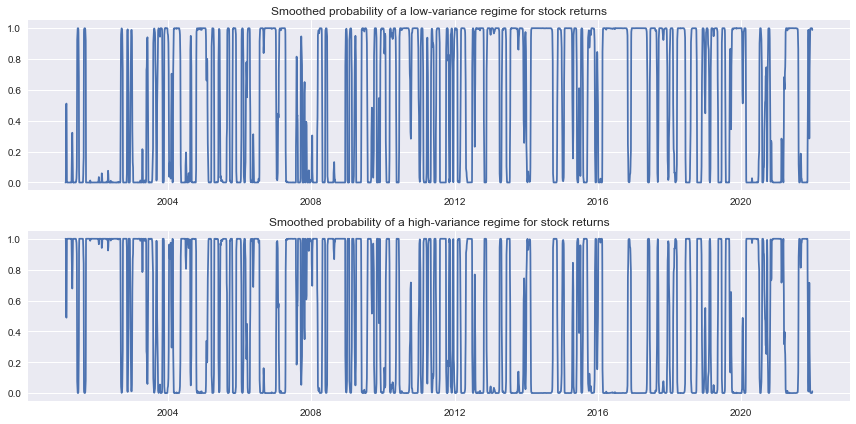

In [69]:
fig, axes = plt.subplots(2, figsize=(12, 6))

ax = axes[0]
ax.plot(res_kospi.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a low-variance regime for stock returns")

ax = axes[1]
ax.plot(res_kospi.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a high-variance regime for stock returns")



fig.tight_layout()

In [70]:
df_kospi_prob= res_kospi.smoothed_marginal_probabilities
df_kospi_prob.columns=[-1,1]
df_kospi_prob= df_kospi_prob.loc["2018":,:]

<AxesSubplot:>

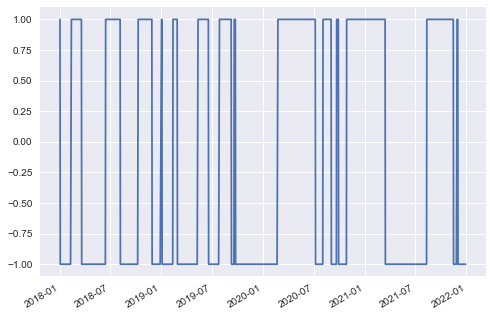

In [71]:
df_kospi_prob.idxmax(axis=1).plot()

In [ ]:
df_kospi_prob.to_csv('4regimes.csv')